In [26]:
import Environment_non_stationary
import Shop
from utilities import *
from mab.ucb_learner import *

In [27]:
shop_ts = Shop.Shop()
shop_c = Shop.Shop()

n_phases = 4
env = Environment_non_stationary.Environment(shop_ts.prices1, shop_ts.prices2, shop_ts.discounts, n_phases)

shop_ts.set_conv_rate(env.true_conv1, env.true_conv2)
shop_c.set_conv_rate(env.true_conv1, env.true_conv2)

price_arms = [(i, j) for i in range(len(shop_ts.prices1)) for j in range(len(shop_ts.prices2))]
n_price_arms = len(price_arms)

matching_arms = [(i, j, k, l) for i in range(len(shop_ts.prices1)) for j in range(len(shop_ts.prices2)) for k in range(shop_ts.n_classes) for l in range(len(shop_ts.discounts))]
n_matching_arms = len(matching_arms)

shop_ts.set_price_learner('TS', n_price_arms)
shop_ts.set_assignment_learner('TS', n_matching_arms)


days=365
frame_size = int(days / env.n_phases)
shop_ts.set_price_learner_sw('TS', n_price_arms, frame_size=frame_size, days=days)
shop_ts.set_assignment_learner_sw('TS', n_matching_arms, frame_size=frame_size, days=days)


In [28]:
generated_promo_ratios = np.array([0.4, 0.25, 0.2, 0.15])
max_ind_reward = max(env.prices1) + max(env.prices2)

In [29]:
"""#get clairvoyants for each phase
shop_c.set_expected_customers(np.array([25, 25, 25, 25]))
cec = shop_c.get_customer_list()
cep = shop_c.get_promo_list(generated_promo_ratios)

c_prices, cpf = shop_c.get_clairvoyants_by_phase(cec, cep, len(env.prices1), len(env.prices2), env.n_phases, price_arms)

"""


'#get clairvoyants for each phase\nshop_c.set_expected_customers(np.array([25, 25, 25, 25]))\ncec = shop_c.get_customer_list()\ncep = shop_c.get_promo_list(generated_promo_ratios)\n\nc_prices, cpf = shop_c.get_clairvoyants_by_phase(cec, cep, len(env.prices1), len(env.prices2), env.n_phases, price_arms)\n\n'

In [30]:
shop_c.set_expected_customers(np.array([25, 25, 25, 25]))
cec = shop_c.get_customer_list()
cep = shop_c.get_promo_list(generated_promo_ratios)

clairvoyant_promo_fractions = []
clairvoyant_p1s = []
clairvoyant_p2s = []
clairvoyant_p1_idxs = []
clairvoyant_p2_idxs = []
for i in range(env.n_phases):
    shop_c.set_conv_rate(env.true_conv1[i], env.true_conv2[i])

    cmt, cpa, cer, ers  = shop_c.get_clairvoyant_prices_and_matching(cec, cep, 5, 5)
    cp1idx = price_arms[cpa][0]
    cp2idx = price_arms[cpa][1]
    cp1 = env.prices1[cp1idx]
    cp2 = env.prices2[cp2idx]

    cpf = shop_c.get_promo_fractions_from_tuples(cmt)

    clairvoyant_promo_fractions.append(cpf)
    clairvoyant_p1s.append(cp1)
    clairvoyant_p2s.append(cp2)
    clairvoyant_p1_idxs.append(cp1idx)
    clairvoyant_p2_idxs.append(cp2idx)


In [31]:
clairvoyant_promo_fractions

[array([[1. , 0. , 0. , 0. ],
        [0.6, 0. , 0. , 0.4],
        [0. , 0. , 0.8, 0.2],
        [0. , 1. , 0. , 0. ]]),
 array([[0. , 0.2, 0.8, 0. ],
        [0.6, 0. , 0. , 0.4],
        [1. , 0. , 0. , 0. ],
        [0. , 0.8, 0. , 0.2]]),
 array([[0.2, 0. , 0.8, 0. ],
        [0.4, 0. , 0. , 0.6],
        [0. , 1. , 0. , 0. ],
        [1. , 0. , 0. , 0. ]]),
 array([[0. , 0.2, 0.8, 0. ],
        [0.2, 0.8, 0. , 0. ],
        [1. , 0. , 0. , 0. ],
        [0.4, 0. , 0. , 0.6]])]

In [32]:
ts_rewards_per_day = []
ts_sw_rewards_per_day = []
c_rewards_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])

for day in range(days):
    if day == 0:
        shop_ts.set_expected_customers(customers_ie)
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))

    # 2-step learner with no sliding window
    price_arm_idx_ts = shop_ts.price_learner.pull_arm()

    price1idx_ts = price_arms[price_arm_idx_ts][0]
    price2idx_ts = price_arms[price_arm_idx_ts][1]
    price1_ts = env.prices1[price_arms[price_arm_idx_ts][0]]
    price2_ts = env.prices2[price_arms[price_arm_idx_ts][1]]

    expected_customers_ts = shop_ts.get_customer_list()
    expected_promos_ts = shop_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_ts = shop_ts.assignment_learner.pull_arm_matching(expected_customers_ts, expected_promos_ts, matching_arms, price1idx_ts, price2idx_ts)
    promo_fractions_ts = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts)

    # 2-step learner with sliding window
    price_arm_idx_ts_sw = shop_ts.price_learner_sw.pull_arm(day)

    price1idx_ts_sw = price_arms[price_arm_idx_ts_sw][0]
    price2idx_ts_sw = price_arms[price_arm_idx_ts_sw][1]
    price1_ts_sw = env.prices1[price_arms[price_arm_idx_ts_sw][0]]
    price2_ts_sw = env.prices2[price_arms[price_arm_idx_ts_sw][1]]

    expected_customers_ts_sw = shop_ts.get_customer_list()
    expected_promos_ts_sw = shop_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_ts_sw = shop_ts.assignment_learner_sw.pull_arm_matching(expected_customers_ts_sw, expected_promos_ts_sw, matching_arms, day, price1idx_ts_sw, price2idx_ts_sw)
    promo_fractions_ts_sw = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts_sw)

    # simulate the day
    env.generate_next_day_customers()

    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    revenue_ts = []
    revenue_ts_sw = []
    revenue_c = []

    ts_total_reward = 0
    ts_sw_total_reward = 0

    c_count = 0

    phase = env.get_phase(days) % env.n_phases
    
    for cust in customers:

        selected_promo_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts[cust])
        selected_promo_ts_sw = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts_sw[cust])
        selected_promo_c = np.random.choice([0, 1, 2, 3], 1, p=clairvoyant_promo_fractions[phase][cust])

        ts_buy1 = env.round1(cust, price1_ts, days)
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = env.round2(cust, selected_promo_ts, price2_ts, days)

        c_buy1 = env.round1(cust, clairvoyant_p1s[phase], days)
        c_buy2 = 0
        if c_buy1:
            c_buy2 = env.round2(cust, selected_promo_c, clairvoyant_p2s[phase], days)

        ts_sw_buy1 = env.round1(cust, price1_ts_sw, days)
        ts_sw_buy2 = 0
        if ts_sw_buy1:
            ts_sw_buy2 = env.round2(cust, selected_promo_ts_sw, price2_ts_sw, days)

        ts_ind_reward = ts_buy1*price1_ts + ts_buy2*price2_ts*(1-shop_ts.discounts[selected_promo_ts])
        ts_sw_ind_reward = ts_sw_buy1*price1_ts_sw + ts_sw_buy2*price2_ts_sw*(1-shop_ts.discounts[selected_promo_ts_sw])
        c_ind_reward = c_buy1*clairvoyant_p1s[phase] + c_buy2*clairvoyant_p2s[phase]*(1-shop_c.discounts[selected_promo_c])

        norm_ts_ind_reward = ts_ind_reward / max_ind_reward
        norm_ts_sw_ind_reward = ts_sw_ind_reward / max_ind_reward

        # update 2-step learner with no sliding window
        shop_ts.price_learner.update(price_arm_idx_ts, norm_ts_ind_reward)

        matching_arm_index_ts = matching_arms.index((price1idx_ts, price2idx_ts, cust, selected_promo_ts))
        shop_ts.assignment_learner.update(matching_arm_index_ts, norm_ts_ind_reward)

        # update 2-step learner with sliding window
        shop_ts.price_learner_sw.update(price_arm_idx_ts_sw, norm_ts_sw_ind_reward, day)

        matching_arm_index_ts_sw = matching_arms.index((price1idx_ts_sw, price2idx_ts_sw, cust, selected_promo_ts_sw))
        shop_ts.assignment_learner_sw.update(matching_arm_index_ts_sw, norm_ts_sw_ind_reward, day)

        revenue_ts.append(ts_ind_reward)
        revenue_ts_sw.append(ts_sw_ind_reward)
        revenue_c.append(c_ind_reward)
    
    pl_day_to_del, pl_rew_dl, pl_n_del, pl_bp0, pl_bp1 = shop_ts.price_learner_sw.end_of_day(day)
    al_day_to_del, al_rew_dl, al_n_del, al_bp0, al_bp1 = shop_ts.assignment_learner_sw.end_of_day(day)

    """print("DAY:", day)
    print("SW Pulled Arm:", )
    print("***********NO SW*****************")
    print(shop_ts.price_learner.beta_parameters)
    print("**************SW*****************")
    print(shop_ts.price_learner_sw.beta_parameters)
    print()"""

    ts_rewards_per_day.append(np.mean(revenue_ts))
    ts_sw_rewards_per_day.append(np.mean(revenue_ts_sw))
    c_rewards_per_day.append(np.mean(revenue_c))
    



Text(0, 0.5, 'Revenue')

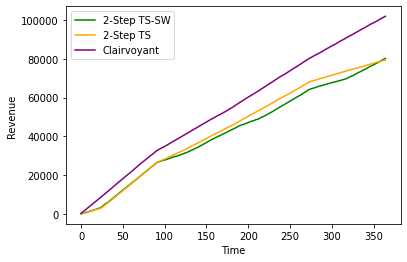

In [33]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(ts_sw_rewards_per_day), color='green', label='2-Step TS-SW')
plt.plot(np.cumsum(ts_rewards_per_day), color='orange', label='2-Step TS')
plt.plot(np.cumsum(c_rewards_per_day), color='purple', label='Clairvoyant')
#plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='red', label='2-step TS')
#plt.plot(np.cumsum(big_ts_rewards_per_class_per_day), color='blue', label='Big TS')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

In [18]:
len(shop_ts.assignment_learner_sw.collected_rewards[40])

365

In [19]:
n_matching_arms

400